<a href="https://colab.research.google.com/github/danfolador/REDES/blob/main/REDES_Exercicio04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCÍCIO 04**

Aluno: Daniel Folador Rossi

Matrícula: 20201mpca0306

---

Nos vídeos, as arquiteturas e algoritmos foram testados, em geral, com resubstituição.

Verifique o desempenho da ELM criando um novo dataset, usando a mesma função de criação do dataset.




In [1]:
#======================================================
# INICIALIZAÇÃO
#======================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
#======================================================
# FUNCOES AUXILIARES
#======================================================
def PlotaRegiao(X, y, modelo, acuracia):
    
    
    h = 0.05
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    
    Xreg = np.c_[xx1.ravel(), xx2.ravel()]
    yreg = modelo.predict(Xreg)


    n_classes = len(set(y))
    levmin = min(set(y))-0.01
    levmax = max(set(y))+0.01

    levels=np.linspace(levmin,levmax,n_classes+1)
    cmap=plt.get_cmap('Paired')
    
    PlotaDataSet(X, y, transp=.2)
    plt.annotate('acuracia= ' + str(acuracia), xy=(0.05, 0.05), xycoords='axes fraction', color='red')
    plt.tricontourf(Xreg[:,0], Xreg[:,1], yreg, cmap=cmap, levels=levels, alpha=0.3)
    
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    
    return Xreg, yreg


def GeraDataSet_SepLin(tamanho=20, centros=4, random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, center_box=(0,1.0), cluster_std=0.05, random_state=random_state)
    return X, y

def GeraDataSet_NaoSepLin(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]], random_state=None):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.05, random_state=random_state)
    y = np.array(y%2, dtype=int)
    return X, y

def PlotaDataSet(X, y, transp):
    
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    #plota pra cada classe
    for k in set(y):
        logic = y==k
        plt.plot(X[:,0][logic], X[:,1][logic], 'o', alpha=transp)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

def CriaCategoricos(y):
    replacements = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f'}
    replacer = replacements.get
    y = [replacer(n, n) for n in y]
    return y

def TrataRotulos(y):
    # Substitui por rótulos numéricos
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    
    # Para o caso binário, substitui por -1/+1
    if len(set(y))<=2: y = y*2-1
    return y


In [3]:
#======================================================
# ALGORITMOS
#======================================================

# PSEUDO-INVERSA
#--------------------------------------------------
class PseudoInversa():
    def __init__(self):
        pass
    def getw(self, X, y):
        w = np.random.uniform(-1, 1,size=(X.shape[1], y.shape[1]))
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

In [4]:
#======================================================
# ELM
#======================================================
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit


def tanh(a):
    return expit(a)*2-1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    
    # INIT
    #--------------------------------------------------
    def __init__(self, algoritmo=PseudoInversa(), threshold=0):
        self.wih = None
        self.w = None
        self.threshold = threshold
        #self.activation = lambda a: (a>=0)*2 -1
        self.activation = tanh
        self.algoritmo = algoritmo
    
    # BIAS
    #--------------------------------------------------
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    # FIT
    #--------------------------------------------------        
    def fit(self,X,y):
        
        #Pesos de input da camada hidden
        #vamos usar k vezes o número de características de X
        k = 3
        self.wih = np.random.uniform(size=(X.shape[1], X.shape[1]*k))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        
        # Treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getw(X, y, self.activation)    
        else:
            self.w = self.algoritmo.getw(X, y)


    # PREDICT
    #--------------------------------------------------     
    def predict(self,X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)       
        Xb = ExtremeLearningMachine.includebias(Xho)  #Vamos usar o bias apenas na camada de saída
        a = np.matmul(Xb, self.w)
            
        #Caso binário
        if self.w.shape[1]<=1:
            logic = self.activation(a) > self.threshold
            idx = np.array(logic, dtype=int)[:,0]
        #Caso multiclasse
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])     

        return ypred

In [5]:
#======================================================
# FUNCAO AJUSTE
#======================================================
def Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, plota_vetor):

    # AJUSTE
    #------------------------------------------------------      
    modelo.fit(Xtrain, ytrain)
    ypred = modelo.predict(Xtest)             #Prediçao com resubstituição
    acuracia = sum(ytest==ypred)/len(ytest)

    # Caso Binário
    if len(set(ytest))<=2:
        pesos = modelo.w[1:]
        bias = modelo.w[0]
       
    # Caso Multiclasse
    else:
        for i in range(len(set(ytest))):
            pesos = modelo.w[1:,i]
            bias = modelo.w[0,i]

    pesos = modelo.w[1:]
    bias = modelo.w[0]

    
    return pesos, bias, acuracia

In [6]:
#======================================================
# BANCO DE DADOS
#======================================================   
# Gera dados
n_classes = 4
lin_sep = 1
datasets=[]

#Linearmente Separados
for _ in range(2):
    X, y = GeraDataSet_SepLin(200, centros=n_classes)
    y = CriaCategoricos(y)
    datasets.append((X,y))
    
    df1 = pd.DataFrame(X, columns=['X1','X2'])
    df2 = pd.DataFrame(y, columns=['y'])
    df = pd.concat([df1, df2],axis=1)
    print(df.head(10))
    print()

#Não-Linearmente Separados
for _ in range(2):
    X, y = GeraDataSet_NaoSepLin(200, centros=n_classes)   
    y = CriaCategoricos(y)
    datasets.append((X,y))
    
    df1 = pd.DataFrame(X, columns=['X1','X2'])
    df2 = pd.DataFrame(y, columns=['y'])
    df = pd.concat([df1, df2],axis=1)
    print(df.head(10))
    print()

         X1        X2  y
0  0.915508  0.571680  a
1  0.202718  1.027452  b
2  0.993947  0.531909  a
3  0.190759  0.592979  c
4  0.259672 -0.001781  d
5  0.090276  0.976809  b
6  0.928321  0.520705  a
7  0.079702  0.567909  c
8  0.227807  0.065941  d
9  0.155784  1.075345  b

         X1        X2  y
0  0.356827  0.114114  b
1  0.745124  0.770532  c
2  0.077481  0.163658  a
3  0.675431  0.341748  d
4  0.197525  0.174642  a
5  0.777011  0.727953  c
6  0.146517  0.108740  a
7  0.122869  0.148292  a
8  0.163283  0.150255  a
9  0.240608  0.218973  a

         X1        X2  y
0  7.035469 -0.914171  a
1  3.634925 -6.404266  a
2  3.679813 -6.335006  a
3 -2.619874  4.069838  b
4 -2.614119  4.188854  b
5  7.058862 -0.844641  a
6  9.302094  6.680567  b
7 -2.586041  4.178932  b
8  9.318048  6.586916  b
9 -2.639578  4.230835  b

         X1        X2  y
0  3.949733 -4.332793  a
1  7.553892 -3.241030  b
2  7.616775 -3.261401  b
3 -5.285554 -4.329488  a
4  3.874036 -4.293010  a
5  7.663942 -3.269143 

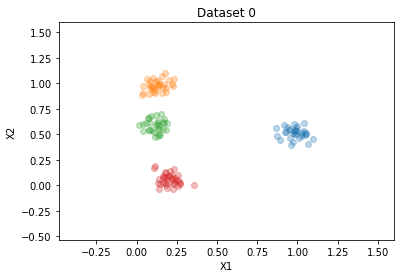


Extreme Learning Machine
--------------------------------------------
bias= [-0.85077758 -1.1113635  -1.15598197  1.11812304]
pesos= [[-3945.63294683  -271.65064251  4013.04184237   204.24174697]
 [-3145.01979544   807.55981375  1274.65488762  1062.80509407]
 [ -764.0327411   -683.67943953  2091.88015055  -644.16796992]
 [ 4074.37340966  1282.85549958 -5566.85480791   209.62589866]
 [ 3323.24106157  -413.95790583 -2522.39205689  -386.89109885]
 [ -586.53984167  -728.06564303  1679.73770202  -365.13221731]]
acuracia= 1.0



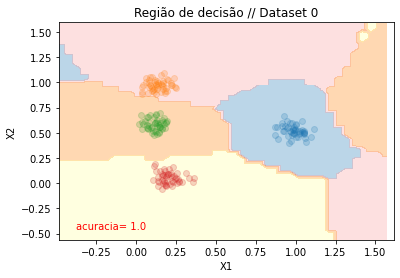

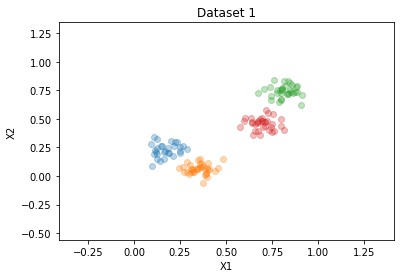


Extreme Learning Machine
--------------------------------------------
bias= [ 0.4614724  -0.05881796 -0.42014343 -1.98251101]
pesos= [[-21130.17787714   3917.09170609   5730.5703157   11482.51585535]
 [  2476.85961373   -269.28376256   -699.08557196  -1508.49027921]
 [ -8477.75528207   1646.31798652   2395.45927692   4435.97801863]
 [ 67023.74369064 -11989.25683126 -17761.94300476 -37272.54385462]
 [ -5979.85038877  -2875.11170128    897.87161485   7957.0904752 ]
 [  5622.95126127   2635.41139353   -886.43077733  -7371.93187747]]
acuracia= 0.9924242424242424



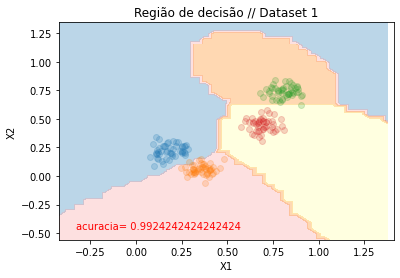

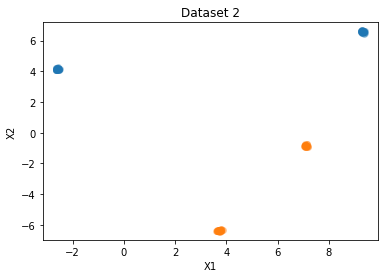


Extreme Learning Machine
--------------------------------------------
bias= [-0.13396458]
pesos= [[ -2.6130454 ]
 [ -1.10958949]
 [ 10.69293898]
 [ 13.78720815]
 [  2.6971474 ]
 [-25.61088344]]
acuracia= 1.0



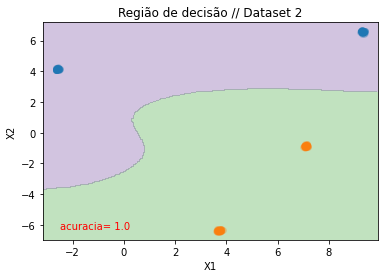

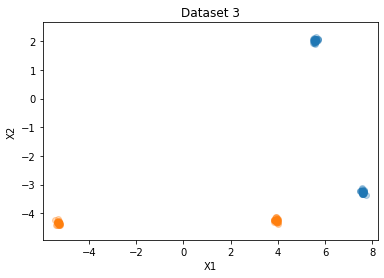


Extreme Learning Machine
--------------------------------------------
bias= [-0.02214763]
pesos= [[ -1.09136162]
 [  4.65239398]
 [ -0.059473  ]
 [ 11.44713645]
 [-10.06423979]
 [ -6.0792637 ]]
acuracia= 1.0



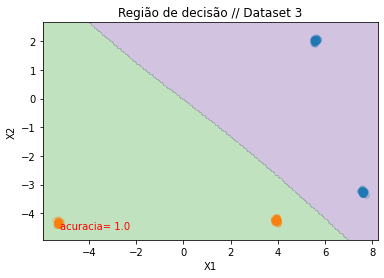

In [7]:
#======================================================
# RODADAS
#======================================================
threshold = 0
modelo = ExtremeLearningMachine(PseudoInversa(),threshold)

i=0
for ds in datasets:
    
    X, y = ds
    y=TrataRotulos(y)

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.66)
    
    plt.title('Extreme Learning Machine')
    PlotaDataSet(Xtest, ytest, transp=0.3)

    ds_name = 'Dataset ' + str(i)
    
    plt.title(ds_name)
    pesos, bias, acuracia = Ajuste(Xtrain, Xtest, ytrain, ytest, modelo, plota_vetor=False)
    plt.show()

    print()
    print('Extreme Learning Machine')
    print('--------------------------------------------')
    print('bias=', bias)
    print('pesos=', pesos)
    print('acuracia=', acuracia)
    print()
    
    plt.title('Região de decisão // ' + ds_name)
    PlotaRegiao(X, y, modelo, acuracia)
    plt.show()
    i+=1


